# Indexing
This notebook contains the work for the indexing part of the assignment

Before indexing, we ran the following query as stated in the assignment:

```sql
SELECT DISTINCT p.full_name
FROM (titles t JOIN cast_info ci ON t.title_id = ci.title_id)
JOIN persons p ON ci.person_id = p.person_id
WHERE (t.primary_title = 'Star Wars: Episode IV - A New Hope')
```

The title was changed from `Star Wars: Episode IV- A New Hope` to `Star Wars: Episode IV - A New Hope` as the prior led to 0 results being found the query resulted in the following table:
|Id | full_name|
|--|------------|
|1 |"Aaron Elliott"|
|2|"Alec Guinness"|
|3|"Calvin Grubb"|
|4|"Carrie Fisher"|
|5|"Doug Walker"|
|6|"Eric Whiteley"|
|7|"Gary Kurtz"|
|8|"Gilbert Taylor"|
|9|"Harrison Ford"|
|10|"John Williams"|
|11|"Mark Hamill"|
|12|"Richard Chew"|
|13|"Richard Martin"|
|14|"Rick McCallum"|
|15|"Ryan George"|
|16|"Shane Farley"|
|17|"Walter Banasiak"|

The query took 02 seconds and 269ms in `EXPLAIN-ANALYZE` mode.

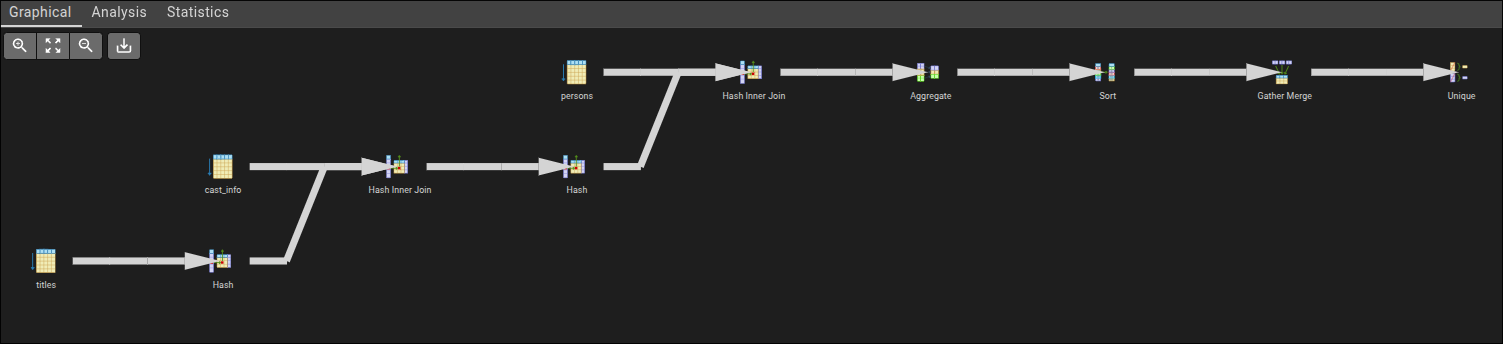

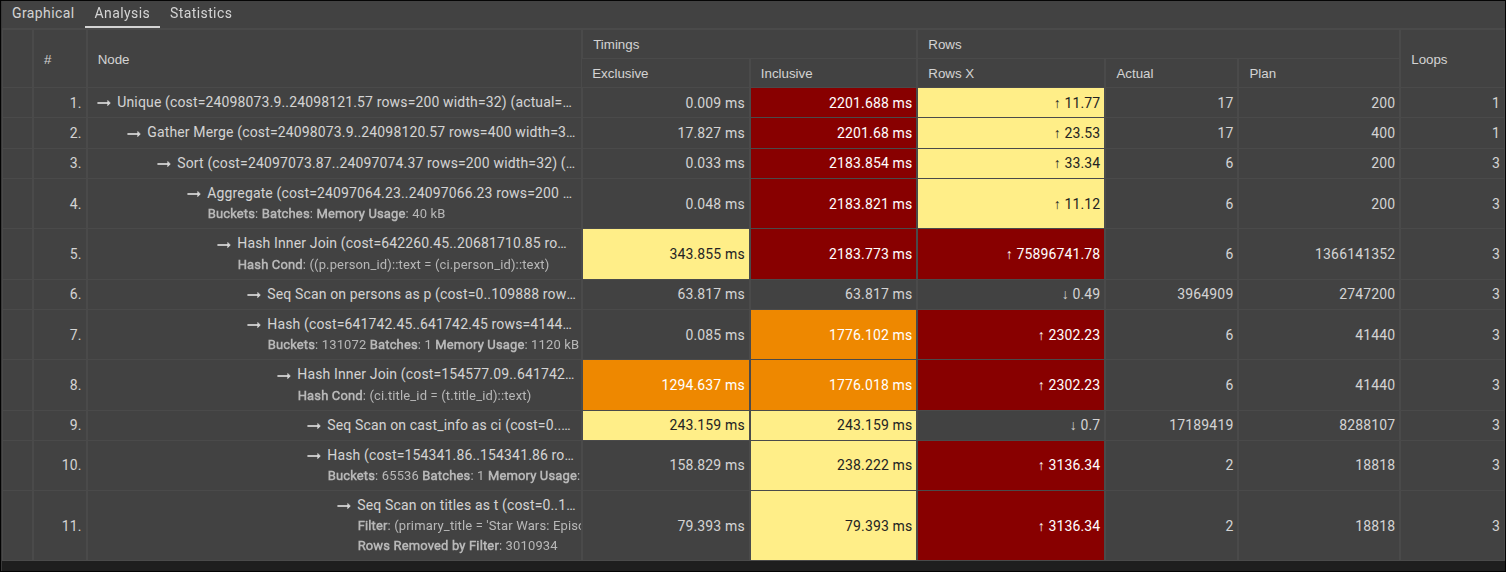

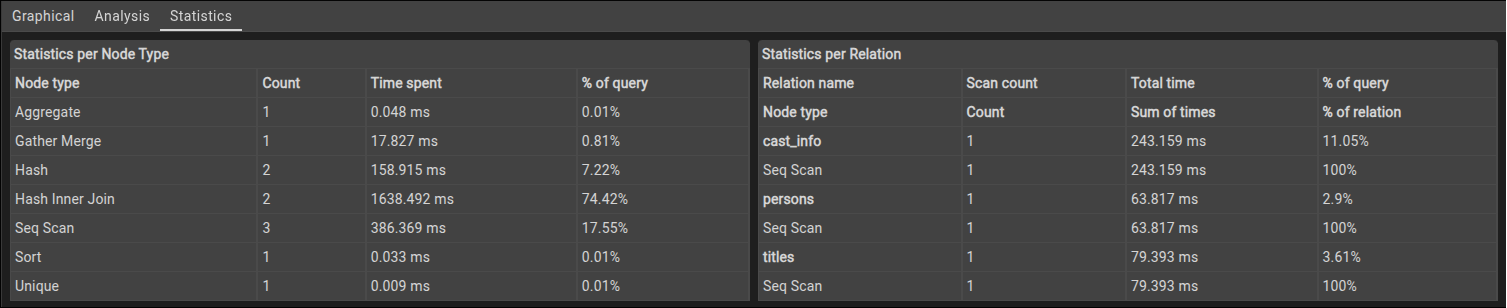



## Making things go faster

To improve the performance we will be using indices. More particularly, we will be using Hash Indices. We will use indices for:
* `titles(primary_title)`
* `cast_info(person_id)`
* `persons(person_id)`

The reason we will be using a hash index for all these and not a B+Tree is due to the fact that none of these are ranged queries, hence hash indices are better suited.

The following commands were used:

```sql
CREATE INDEX idx_primary_title_hash 
ON titles USING hash (primary_title)

CREATE INDEX idx_titles_title_id
ON titles USING hash (title_id)

CREATE INDEX idx_persons_person_id_hash 
ON persons USING hash (person_id)

CREATE INDEX idx_cast_info_person_id_hash 
ON cast_info USING hash (person_id)

CREATE INDEX idx_cast_info_title_id_hash 
ON cast_info USING hash (title_id)
```

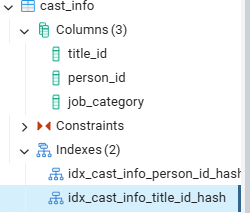


Example of how indexes are seen on pgadmin

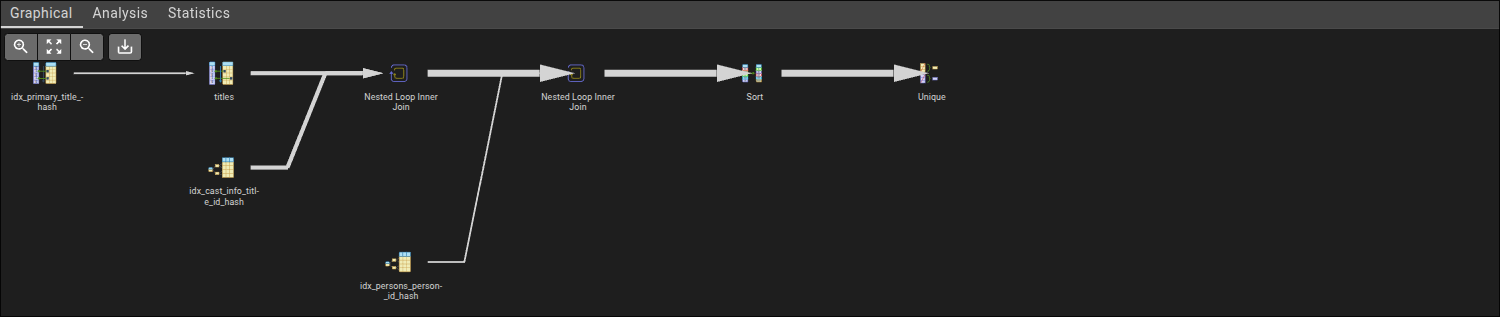

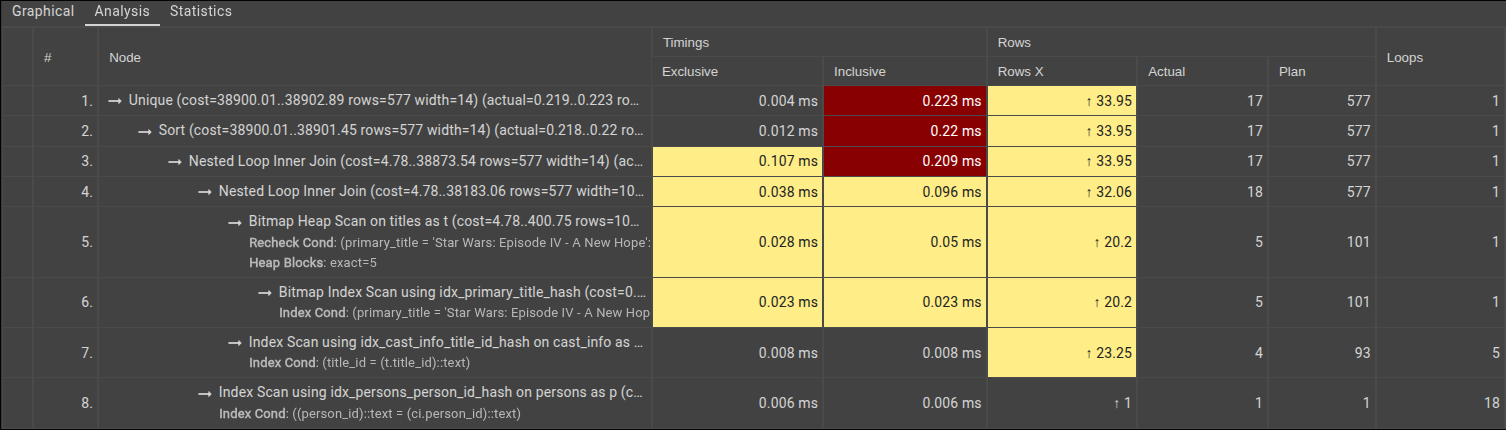

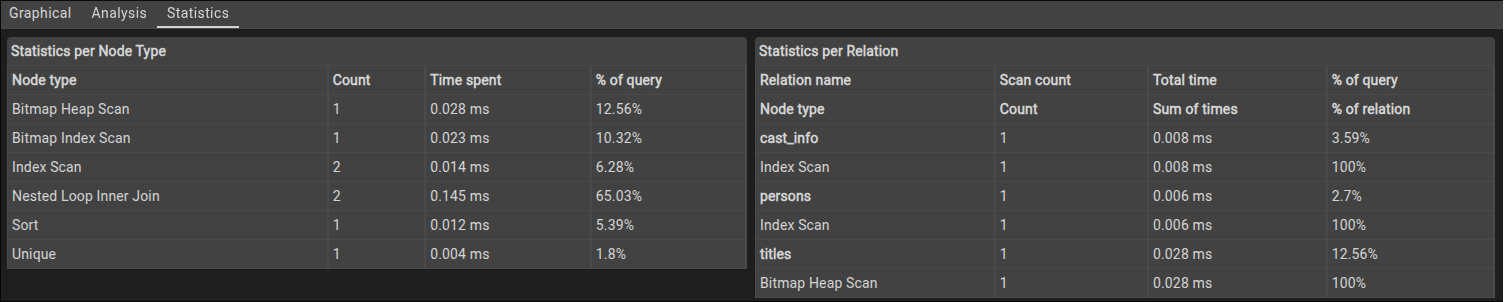

As we can see, with these changes, the time is reduced to 0.023 seconds, which is approximately 100 times faster. This is due to Hash indexes providing an $\mathcal{O}(1)$ lookup which leads to less time being on searching for entries with matching attributes.

## Fixing up the database

We can see that each title can be of the following types:
* "movie"
* "short"
* "tvEpisode"
* "tvMiniSeries"
* "tvMovie"
* "tvPilot"
* "tvSeries"
* "tvShort"
* "tvSpecial"
* "video"
* "videoGame"

Hence, a series and a series episode are both _titles_ and should be foreign keys.

When we try the following: 

```sql
ALTER TABLE episodes
ADD FOREIGN KEY (episode_id)
REFERENCES titles (title_id)
```

It doesn't work sadly as there are episode ids that are not in the titles table so those need to be removed. We can remove them using:

```sql
DELETE FROM episodes WHERE episode_id in (
    SELECT episode_id FROM (episodes LEFT JOIN titles on titles.title_id = episodes.episode_id)  
	WHERE titles.title_id is NULL)
```


Now we can run the previous ALTER command to create the first FK.

When we try to make the `series_id` be a FK to `title_id` with the following:
```sql
ALTER TABLE episodes
ADD FOREIGN KEY (series_id)
REFERENCES titles (title_id)
```
we also get a similar error: `ERROR:  insert or update on table "episodes" violates foreign key constraint "episodes_series_id_fkey" Key (series_id)=(tt0086748) is not present in table "titles". `

Which we can fix by dropping the entries with `series_id`s that do not correspond to a `title_id` with the following:
```sql
DELETE FROM episodes WHERE series_id in (
    SELECT series_id FROM (episodes LEFT JOIN titles on titles.title_id = episodes.series_id)  
	WHERE titles.title_id is NULL)
```

Now we can safely make our foreign key with the previous alter command.

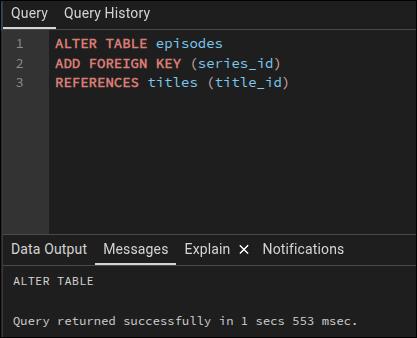

## Running it back

To now do the same query using python we will use PythonDask. To install it we used

```cmd
pip install "dask[complete]"
```

We will also use pandas to benchmark single threaded operations.
```cmd
pip install pandas
```


We then export the CSVs through pgadmin with their headers
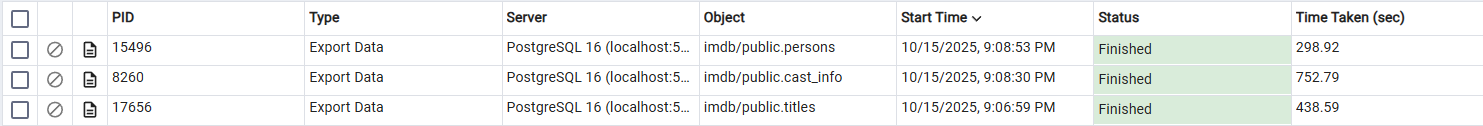

In [1]:
import pandas as pd
import dask.dataframe as dd
import dask.multiprocessing as dask
import time

In [2]:
def run_query_with_processes(workers):
    """
    Run the query using Dask with multiprocessing scheduler.
    """
    dask.config.set( scheduler='processes', num_workers=workers )

    duration = 0

    titles = dd.read_csv("titles.csv",usecols=["title_id","primary_title"])
    cast_info = dd.read_csv("cast_info.csv",usecols=["title_id","person_id"])
    persons = dd.read_csv("persons.csv",usecols=["person_id","full_name"])

    result = titles[titles["primary_title"] == 'Star Wars: Episode IV - A New Hope']
    result = result.merge( cast_info, how="inner", on="title_id" )
    result = result.merge( persons, how="inner", on="person_id" )
    result = result[["full_name"]].drop_duplicates()
    
    start = time.time()
    result = result.compute()
    duration = duration + time.time() - start
    return duration, result

In [3]:
workers=16
elapsed_time, result = run_query_with_processes(workers)
print(f"Elapsed time with parallel processes: {elapsed_time} seconds")
print(f"Result {result}")

Elapsed time with parallel processes: 104.49503517150879 seconds
Result          full_name
0  Walter Banasiak
1    Rick McCallum
0    John Williams
0    Alec Guinness
1     Shane Farley
0    Eric Whiteley
0      Doug Walker
0    Carrie Fisher
1      Mark Hamill
0      Ryan George
0   Richard Martin
0       Gary Kurtz
0     Calvin Grubb
0    Harrison Ford
1     Richard Chew
0   Gilbert Taylor
0    Aaron Elliott


In [4]:
def single_process_query():
    start = time.time()
    titles = pd.read_csv("titles.csv",usecols=["title_id","primary_title"])
    cast_info = pd.read_csv("cast_info.csv",usecols=["title_id","person_id"])
    persons = pd.read_csv("persons.csv",usecols=["person_id","full_name"])

    result = titles[titles["primary_title"] == 'Star Wars: Episode IV - A New Hope']
    result = result.merge( cast_info, how="inner", on="title_id" )
    result = result.merge( persons, how="inner", on="person_id" )
    result = result[["full_name"]].drop_duplicates()
    duration = time.time() - start
    
    return duration, result

In [5]:
elapsed_time, result = single_process_query()
print(f"Elapsed time for serial execution: {elapsed_time} seconds")
print(f"Result {result}")

Elapsed time for serial execution: 35.649786710739136 seconds
Result           full_name
0       Ryan George
1      Calvin Grubb
2    Richard Martin
3     Eric Whiteley
4      Shane Farley
5     Aaron Elliott
6       Doug Walker
7   Walter Banasiak
8     Alec Guinness
9     Harrison Ford
10    Carrie Fisher
11      Mark Hamill
12    John Williams
13     Richard Chew
14       Gary Kurtz
15    Rick McCallum
16   Gilbert Taylor


As we can see, pandas is considerably faster than Dask in this instance. This can be explained by the overhead introduced by Dask for paralellizing the query being too much to justify using it on our database. Moreover, since the code was ran on a laptop with high amounts of RAM, most of data could fit in RAM hence the benefit from using Dask is smaller. This is also noted in the Dask documentation as they recommend switching to pandas when the data amount becomes managable https://docs.dask.org/en/stable/dataframe-best-practices.html. If the data was bigger or the query was built in a way that it returned more results Dask would perhaps be faster than Pandas